In [34]:
import sys
sys.path.append('/nfshome/hassan/QswitchNet')
from network_utils_hybrid import *
import numpy as np
import matplotlib.pyplot as plt
import os
import json


Create a network topology as a json file

This is only an example. Ideally, we want the input to be a drawing in QNDK gui which would be converted into a json file.

In [39]:
# generate a toy topology and save the topology as a .json file

num_qpus = 4
qpu_list = range(1,1+num_qpus)
data_qs_per_qpu = 10
comm_qs_per_qpu = 2
num_bsms = 2
bandwidth = comm_qs_per_qpu
# net1 = {"vertices": {"qpus": qpu_list, "switches":[0]},
#         "edges": {(0,i) for i in qpu_list},
#         "" }

qpu_nodes = {f"q{i}": {"data_q": data_qs_per_qpu, "comm_q": comm_qs_per_qpu}
              for i in qpu_list}
switches = {f"s{0}": {"PD": 0, "BSM_ir": num_bsms, 
                "BSM_tel":0, "Laser": 0, 
                "BS": 0, "ES": 0}}
edges = { "edges": { f"s{0}, q{i}": bandwidth for i in qpu_list} }
network = {"vertices": qpu_nodes | switches } | edges

# print(network)

fname = f"star{num_qpus}.json"
with open(fname, 'w') as json_file:
    json_file.write(json.dumps(network) + '\n')



Input 1: Network

Read a network topology from json and convert to networkx graph

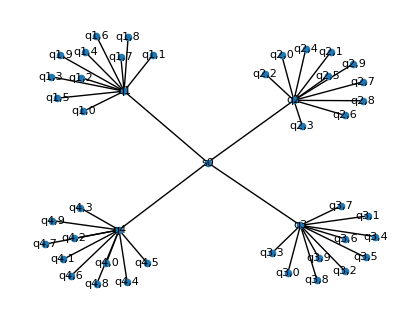

In [40]:
def convert_json_to_nx(fname):
    """
    input: json file name containing the network graph and resources
    output: networkx graph and a list of qpus and switches
    """
    # import json file
    with open(fname) as f:
        network = json.load(f)

    # construct the networkx graph from json file
    G = nx.Graph()
    attrs = {}
    edge_switches = []
    node_list = []
    for i in network["vertices"].keys():
        if i[0] == "s":
            edge_switches.append(i)
        elif i[0] == "q":
            node_list.append(i)

    G.add_nodes_from(edge_switches, type='edge')
    for sw in edge_switches:
        attrs[sw] = network["vertices"][sw]

    G.add_nodes_from(node_list, type='node')
    nx.set_node_attributes(G, attrs)
    # adding data qubits
    node_qubit_list = []
    for node in node_list:
        node_attr = network["vertices"][node]
        for qubit in range(node_attr["data_q"]):
            qname = f"{node},{qubit}"
            node_qubit_list.append(qname)
            G.add_edge(node,qname, weight=1)

    # connecting qpus to switches
    for edge_str in network["edges"].keys():
        nodes = edge_str.replace(" ","").split(",")
        G.add_edge(nodes[0], nodes[1], weight=network["edges"][edge_str])

    vertex_list = edge_switches, node_list, node_qubit_list 

    return G, vertex_list

# example usage
num_qpus = 4
fname = f"star{num_qpus}.json"
G, vertex_list = convert_json_to_nx(fname)
plt.figure(figsize=(4,3))
nx.draw(G, node_size=20, font_size=8, with_labels=True)



Input 2: quantum circuit 

1- Read the circuit from .py file

2- Assign logical qubits to physical qubits (Eneet's code)

In [1]:
import job1

num_qubits = 30
circuit = job1.ghz_circuit(num_qubits)
# draw circuit
# circuit.draw()

_, _, node_qubit_list = vertex_list
## trivial ordering
qubit_map = {i: node_qubit_list[i] for i in range(num_qubits)}
## random ordering
# rand_idx = sorted(range(num_qubits), key = lambda x: random.random())
# qubit_map = {i: node_qubit_list[idx] for i, idx in enumerate(rand_idx)}
print(qubit_map)


30


Run the job scheduler with circuit and network topology as inputs

In [42]:
JSON_PATH = "../data/nir_latency.json"
with open(JSON_PATH) as f:
    time_nir = np.array(json.load(f))

telecom_gen_rate = 1/(1e-2) # ebit average generation time in sec
switch_duration = 1e-3 # average switching delay in sec
nir_prob = 1e-2 # NIR gen prob
qubit_reset = 1e-6 # qubit reset time in sec

switch_seq, circ_depth = eff_network_latency_dag_from_qiskit(G, qubit_map, circuit)
switch_seq = np.array(switch_seq)
print("NIR links, Telecom link:")
print(switch_seq)

tel_latency = 1/telecom_gen_rate * time_spdc(switch_seq[:,1]) 
nir_latency = qubit_reset * np.array([time_nir[k] for k in switch_seq[:,0]])
latency_combined = np.stack((tel_latency,nir_latency), axis = 1)

T_latency =  np.max(latency_combined, axis = 1).sum() + switch_duration * switch_seq.shape[0] 

print(f"Network latency: {T_latency:.4f} sec. over {len(switch_seq):d} switching events")


NIR links, Telecom link:
[[0 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]
 [2 0]]
Network latency: 0.0125 sec. over 11 switching events


# 